# Convolving a source profile to a magnification map
- Assume a source profile that is 10 times larger than its FWHM
- Have a magnification map

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb
import scipy as sci
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys
import time as t
sys.path.append('..')

from IRSMicroLensing import IRSCaustics_automatic as IRSC

Calculating the magnification map of Jupiter and Sun

Creating mesh grid: 0.106 seconds
Calculating source pixels: 1.024 seconds
Calculating indices of translated pixel after deflection: 0.352 seconds
Calculating translated pixels: 0.806 seconds
Finding pixel repetitions and counts: 0.266 seconds
Incrementing pixel magnifications based on counts and repetitions: 0.243 seconds
Plotting magnification map: 0.114 seconds
---------------------
Total time: 3.175 seconds
[[[-0.00123865 -0.00041288]
  [ 0.0034462   0.00114873]
  [-0.00067905  0.00203714]
  [ 0.00067905 -0.00203714]]

 [[-0.00032219  0.00064438]
  [ 0.00066886 -0.00133773]
  [ 0.00092572  0.00046286]
  [-0.00092572 -0.00046286]]]
{'pixels': 5000, 'ang_width': np.float64(0.01378481976316851), 'lens_att': [[0, 0, 0.01, 1], [0.3, 0.1, 0.01, 0.01], [0.1, -0.2, 0.01, 0.01]], 'thickness': np.float64(0.014530475862171783), 'num_r': 12000, 'num_theta': 3000, 'ang_res': np.float64(2.756963952633702e-06), 'pixel_density': np.float64(362717.83642463275), 'dr': np.float64(1.2108729885143152e-

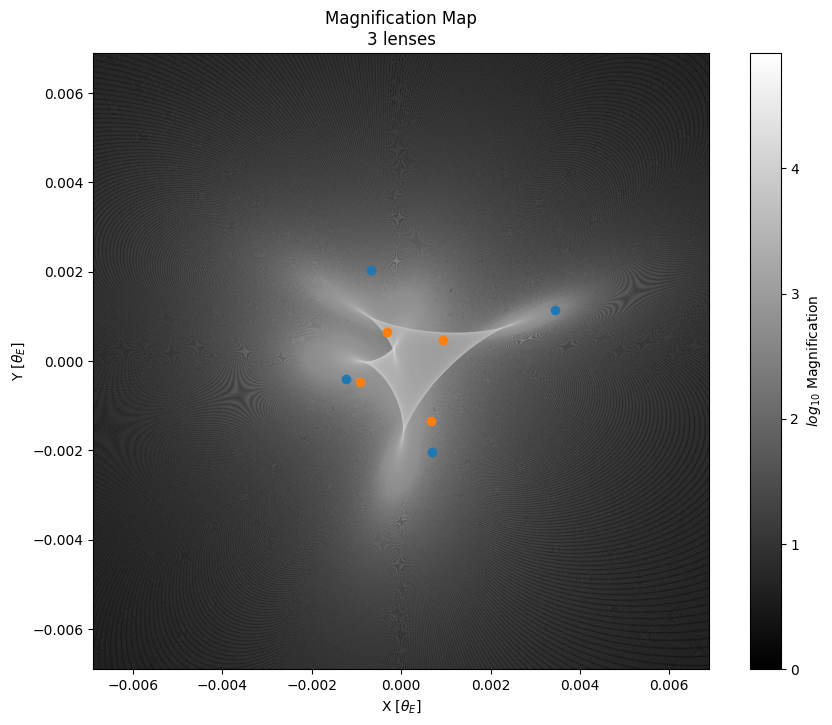

In [ ]:
lens_att = [
    [0, 0, 0.01, 1],
    [0.3, 0.1, 0.01, 0.01],
    [0.1, -0.2, 0.01, 0.01]
]

# param_dict = {'pixels': 10000, 'ang_width': 0.01, 'lens_att': lens_att, 'thickness': 0.05, 'num_r': 12000, 'num_theta': 3000}
# param_dict = {'pixels': 10000, 'ang_width': 'auto', 'lens_att': lens_att, 'thickness': 0.005, 'num_r': 12000, 'num_theta': 3000}
param_dict = {'pixels': 5000, 'ang_width': 'auto', 'lens_att': lens_att, 'thickness': 'auto', 'num_r': 12000, 'num_theta': 3000}
# param_dict = {'pixels': 1000, 'ang_width': 'auto', 'rays_per_pixel': 4, 'lens_att': lens_att}

caus = IRSC.IRSCaustics(annulus_param_dict=param_dict)
# caus = IRSC.IRSCaustics(whole_plane_param_dict=param_dict)
magnifications = caus.plot(show_lenses=False)

# points = np.array([caus.x_pos, caus.x_neg, caus.y_pos, caus.y_neg])

print(caus.points)
ax = caus.fig_c.gca()

for group in caus.points:
    ax.scatter(group[:, 0], group[:, 1])

print(caus.param_dict)

plt.show()

## Stars are uniform sources (0th order) with some limb darkening (1st order)

Gaussian profile:

In [5]:
ang_res = caus.param_dict['ang_res']

R = 1e-3

pix_width = 1*R / ang_res

print(pix_width)

x = np.linspace(-5*R, 5*R, int(pix_width))
y = np.linspace(-5*R, 5*R, int(pix_width))

X, Y = np.meshgrid(x, y)

r2 = X**2 + Y**2

source_profile_gauss = 0.25 * np.exp(-r2*0.5 / R**2)

362.71783642463276


Uniform profile:

In [57]:
ang_res = caus.param_dict['ang_res']

R = 1e-3

pix_width = 1*R / ang_res

print(pix_width)

x = np.linspace(-5*R, 5*R, int(pix_width))
y = np.linspace(-5*R, 5*R, int(pix_width))

X, Y = np.meshgrid(x, y)

r2 = X**2 + Y**2

source_profile = r2 <= R**2

362.71783642463276


Limb darkening:

$S_\lambda(\theta) = \bar{S_\lambda} \left[1 - \Gamma_\lambda \left(1 - \dfrac{3}{2} \cos{\theta}\right) \right]$

$S_\lambda(r) = \bar{S_\lambda} \left[1 - \Gamma_\lambda \left(1 - \dfrac{3}{2} \sqrt{1 - \left(\dfrac{r}{R}\right)^2}\right) \right]$

$\Gamma_\lambda \in [0, 1]$: Limb-darkening coefficient

$\dfrac{r}{R} \in [0, 1]$: Radius of star

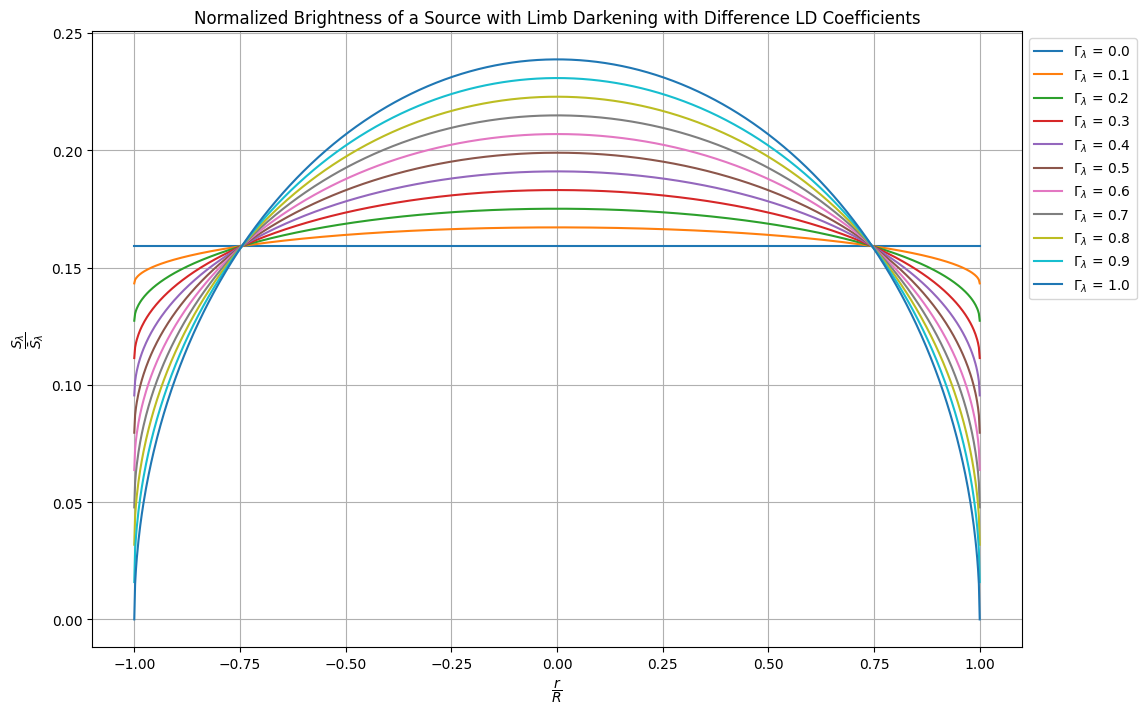

In [3]:
num_LD = 11
num_r = 1001

# Discretizing limb-darkening coefficient
LD_coeff = np.zeros(shape=(num_LD, 1))
LD_coeff[:, 0] = np.linspace(0, 1, num_LD)

# Discretizing radius ratio
r_R = np.zeros(shape=(1, num_r))
r_R[:] = np.linspace(-1, 1, num_r)

# Calculating cos(theta)
cos_theta = np.sqrt(1 - r_R**2)

# Normalized surface brightness
s_lambda = (1 - np.dot(LD_coeff, 1 - 3/2*cos_theta))/(2*np.pi)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, profile in enumerate(s_lambda):
    ax.plot(r_R.transpose(), profile, label=f'$\Gamma_\lambda$ = {round(LD_coeff[i, 0], 1)}')
    # ax.plot(r_R.transpose(), profile)

# ax.set_aspect('equal')
ax.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.set_xlabel('$\dfrac{r}{R}$')
ax.set_ylabel('$\dfrac{S_\lambda}{\\bar S_\lambda}$')
ax.set_title('Normalized Brightness of a Source with Limb Darkening with Difference LD Coefficients')

fig.savefig('Limb Darkening.png', dpi=300)
plt.show()

362.71783642463276
0.0
0.125
0.25
0.375
0.5
0.625
0.75
0.875
1.0


/var/folders/39/mb5cwg0x4h18n1y377g5rs9c0000gn/T/ipykernel_90122/684701595.py:24: RuntimeWarning: invalid value encountered in sqrt
  cos_theta = np.nan_to_num(np.sqrt(1 - (r2 / R**2)), nan=0)


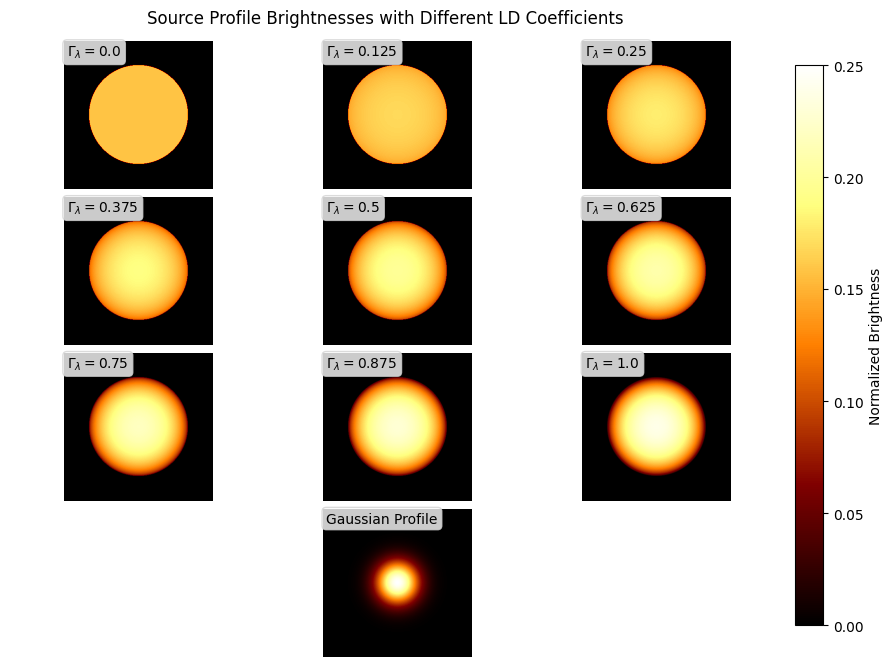

In [ ]:
import matplotlib.gridspec as gridspec

ang_res = caus.param_dict['ang_res']

R = 1e-3

pix_width = 1*R / ang_res

print(pix_width)

ang_width = 1.5*R

x = np.linspace(-ang_width, ang_width, int(pix_width))
y = np.linspace(-ang_width, ang_width, int(pix_width))

X, Y = np.meshgrid(x, y)

r2 = X**2 + Y**2

# Discretizing limb-darkening coefficient
LD_coeffs = np.linspace(0, 1, 9)

# Defining source profile brightnesses
cos_theta = np.nan_to_num(np.sqrt(1 - (r2 / R**2)), nan=0)

source_profiles = np.zeros(shape=(9, X.shape[0], X.shape[1]))

for i, LD_coeff in enumerate(LD_coeffs):
    print(LD_coeff)
    source_profiles[i, :, :] = ((1 - (LD_coeff * (1 - (3/2 * cos_theta))))/(2*np.pi)) * (r2 <= R**2)

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 3, figure=fig, wspace=0.01)
axes = fig.subplots(4, 3)
# ax = fig.add_subplot()

# axes[0, 0].imshow(source_profiles[0], cmap='afmhot', extent=[-ang_width, ang_width, -ang_width, ang_width])
# ax.imshow(source_profiles[0], cmap='afmhot', extent=[-ang_width, ang_width, -ang_width, ang_width])

for i, source_profile in enumerate(source_profiles):
    if i < 3:
        ax = axes[0, i]
    elif i < 6:
        ax = axes[1, i-3]
    else:
        ax = axes[2, i-6]
    
    plot = ax.imshow(source_profile, cmap='afmhot', extent=[-ang_width, ang_width, -ang_width, ang_width], vmin=0, vmax=0.25)
    ax.axis('off')

    props = dict(boxstyle='round', facecolor='white', edgecolor='lightgray', alpha=0.8)
    ax.text(0.02, 0.98, f'$\Gamma_\lambda = {LD_coeffs[i]}$', va='top', zorder=10, bbox=props, transform=ax.transAxes)

for i in range(0, 3):
    axes[3, i].axis('off')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_ax.axis('off')

axes[3, 1].imshow(source_profile_gauss, cmap='afmhot', extent=[-ang_width, ang_width, -ang_width, ang_width], vmin=0, vmax=0.25)
props = dict(boxstyle='round', facecolor='white', edgecolor='lightgray', alpha=0.8)
axes[3, 1].text(0.02, 0.98, f'Gaussian Profile', va='top', zorder=10, bbox=props, transform=axes[3, 1].transAxes)

bar = fig.colorbar(plot, ax=cbar_ax, location='right', fraction=1.5, aspect=20)
bar.set_label('Normalized Brightness')

fig.suptitle('Source Profile Brightnesses with Different LD Coefficients', y=0.92)

# fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0.02)
plt.subplots_adjust(wspace=0.01, hspace=0.05)

# plt.tight_layout()
# axes[0, 1].set_title('Source Profile Brightnesses with Different LD Coefficients')

# fig.savefig('Limb-Darkened Source Profiles.png', dpi=300)
plt.show()

## Profile:

0.5


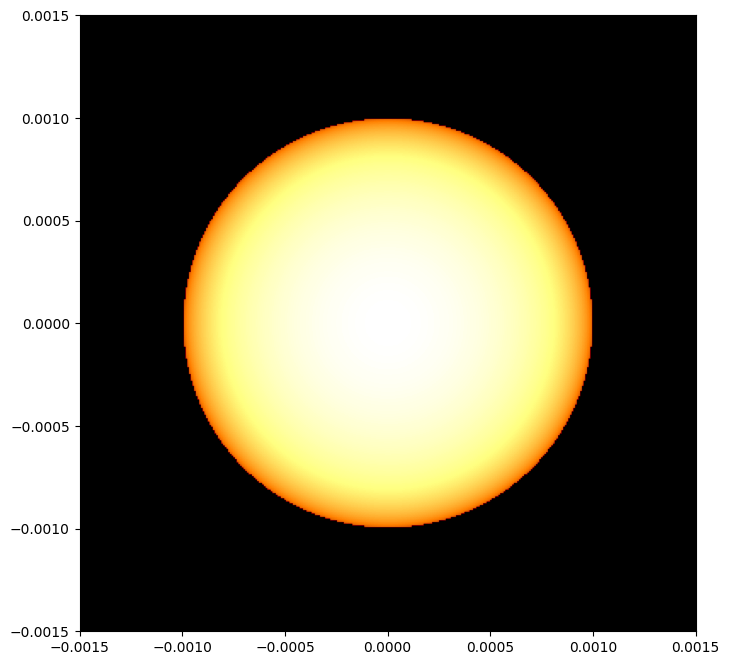

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

index = 4

print(LD_coeffs[index])
ax.imshow(source_profiles[index], cmap='afmhot', extent=[-ang_width, ang_width, -ang_width, ang_width])

plt.show()

## Size of source with respect to magnification map

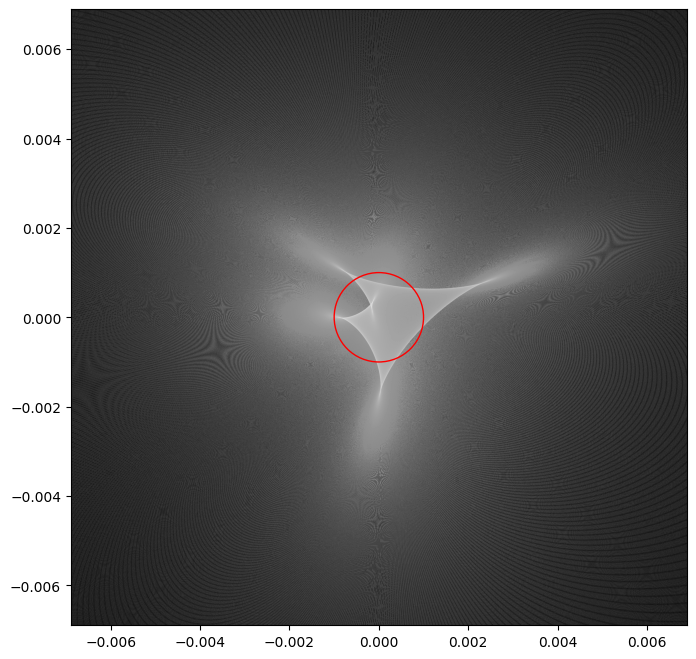

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.imshow(caus.magnifications_log, cmap='gray', extent=[-caus.ang_width/2, caus.ang_width/2, -caus.ang_width/2, caus.ang_width/2])

source_patch = patches.Circle((0, 0), R, fill=False, edgecolor='red', zorder=10)
ax.add_patch(source_patch)

plt.show()

## Convolution operations

#### Numba Jit Convolution Function

In [8]:
# Convolution function
@nb.jit(nb.float64[:, :](nb.int64[:, :], nb.float64[:, :], nb.float64[:, :]), nopython=True, parallel=True, fastmath=True)
def convolution_parallel(mat, fil, res):
    '''
    Performs convolution on a 2d square matrix.
    Expects a kernel with same height and width.
    '''
    
    row_range = col_range = len(mat)-len(fil)+1
    ker_sz=len(fil)
    for row in nb.prange(row_range):
        for col in nb.prange(col_range):

            # Elementwise multiplication of input submat with kernel 
            submat = mat[row:row+ker_sz, col:col+ker_sz]
            # Sum up the values and add bias
            respix = np.sum(submat*fil)

            res[row, col] = respix

    # l2 = fil.size // 2
    # res = np.empty(mat.shape)
    # for i in range(mat.shape[1]):
    #     res[:, i] = np.convolve(mat[:, i], fil)[l2:-l2]
    # return res

    # # Get the dimensions of the image and kernel
    # image_height, image_width = mat.shape
    # kernel_height, kernel_width = fil.shape

    # # Calculate the output dimensions
    # output_height = image_height - kernel_height + 1
    # output_width = image_width - kernel_width + 1

    # # Perform convolution
    # for i in range(output_height):
    #     for j in range(output_width):
    #         res[i, j] = np.sum(mat[i:i+kernel_height, j:j+kernel_width] * fil)

    return res

### SciPi NDImage Convolution (very slow)

In [48]:
print('Starting convolution')
i_time = t.time()
ans = sci.ndimage.convolve(magnifications, source_profile)
print(np.shape(ans))
print(t.time() - i_time)
print('Finished')

Starting convolution
(5000, 5000)
102.43251609802246
Finished


### SciPy Fast Fourier Transform Convolution (fastest)

In [9]:
print('Starting convolution')
i_time = t.time()
ans = sci.signal.fftconvolve(magnifications, source_profiles[index], 'same')
print(np.shape(ans))
print(t.time() - i_time)
print('Finished')

Starting convolution
(5000, 5000)
1.1349079608917236
Finished


### Numba Jit Convolution (takes way too long)

In [ ]:
test_out = np.zeros((20, 20), dtype=np.float64)
im = np.random.randint(0, 10, (20, 20))
filt = np.random.rand(3, 3)

test_out = convolution_parallel(im, filt, test_out)


print('Starting convolution')
i_time = t.time()

ans = np.zeros(magnifications.shape, dtype=np.float64)
ans = convolution_parallel(magnifications, source_profile, ans)

print(np.shape(ans))
print(t.time() - i_time)
print('Finished')

Starting convolution


## Convolving source profile with magnification map

In [13]:
convolved_magnifications_log = []

for i, source_profile in enumerate(source_profiles):
    i_time = t.time()
    ans = sci.signal.fftconvolve(magnifications, source_profile, 'same')
    print(i, t.time() - i_time)

    # magnifications_log = np.where(ans == 0, 0.1, ans)
    # magnifications_log = np.log10(magnifications_log)
    # magnifications_log = np.where(magnifications_log == -1, 0, magnifications_log)

    convolved_magnifications_log.append(ans)

0 1.1171770095825195
1 1.0071790218353271
2 0.9856071472167969
3 1.0751280784606934
4 1.0626201629638672
5 1.046938180923462
6 1.0304639339447021
7 1.119157075881958
8 1.0835011005401611


In [14]:
print(np.amax(np.array(convolved_magnifications_log)))

23463986.161066458


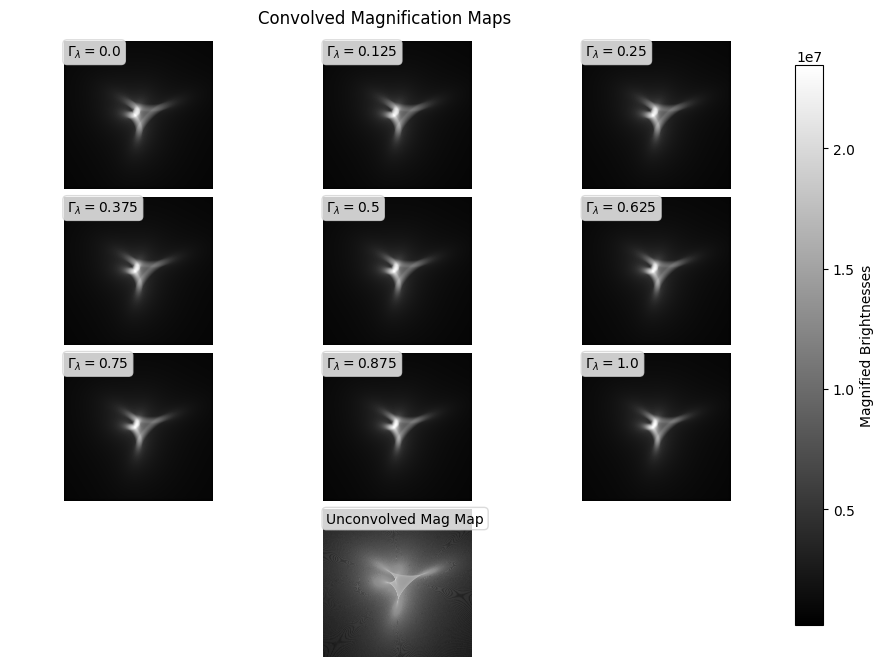

In [17]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 3, figure=fig, wspace=0.01)
axes = fig.subplots(4, 3)

for i, mag_map in enumerate(convolved_magnifications_log):
    if i < 3:
        ax = axes[0, i]
    elif i < 6:
        ax = axes[1, i-3]
    else:
        ax = axes[2, i-6]
    
    plot = ax.imshow(mag_map, cmap='gray', extent=[-caus.ang_width/2, caus.ang_width/2, -caus.ang_width/2, caus.ang_width/2])
    ax.axis('off')

    props = dict(boxstyle='round', facecolor='white', edgecolor='lightgray', alpha=0.8)
    ax.text(0.02, 0.98, f'$\Gamma_\lambda = {LD_coeffs[i]}$', va='top', zorder=10, bbox=props, transform=ax.transAxes)

for i in range(0, 3):
    axes[3, i].axis('off')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_ax.axis('off')

axes[3, 1].imshow(caus.magnifications_log, cmap='gray', extent=[-caus.ang_width/2, caus.ang_width/2, -caus.ang_width/2, caus.ang_width/2])
props = dict(boxstyle='round', facecolor='white', edgecolor='lightgray', alpha=0.8)
axes[3, 1].text(0.02, 0.98, f'Unconvolved Mag Map', va='top', zorder=10, bbox=props, transform=axes[3, 1].transAxes)

bar = fig.colorbar(plot, ax=cbar_ax, location='right', fraction=1.5, aspect=20)
bar.set_label('Magnified Brightnesses')

fig.suptitle('Convolved Magnification Maps', y=0.92)

# fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0.02)
plt.subplots_adjust(wspace=0.01, hspace=0.05)

# plt.tight_layout()
# axes[0, 1].set_title('Source Profile Brightnesses with Different LD Coefficients')

# fig.savefig('Limb-Darkened Source Profiles.png', dpi=300)
plt.show()

Subtract convolved single lens magnification map (analytic) from this and then plot fractional deviations:
- Want to explore how small of a mass ratio you can detect the second planet
- Plot difference of this magnification map and most massive planet and star
- See how small you can make the small planet before it is nondetectable
- Later: add additional planets

Triple - binary / binary
- Plot grid of changing seperation and planet mass ratio to see how c=deviation changes
- Later on explore multiple planets and then adding moons...
- Later later on add in orbital motion and see what happens

Trajectories:
- Through fractional deviation map